In [32]:
from config import default_arguments
from utils import set_seeds
from ipt.data import get_dataset, get_dataloader
from ipt.networks import APTNet

In [33]:
from IPython.display import clear_output
from torchvision import transforms
import matplotlib.pyplot as plt

def show_image(image): 
    plt.imshow(transforms.ToPILImage()(image.cpu().detach().squeeze()))
    plt.show()

In [34]:
import torch
import torch.nn as nn
from tqdm import tqdm

class Classifier(nn.Module):
    def __init__(self, args):
        super(Classifier, self).__init__()
        self.args = args
        self.conv1 = nn.Conv2d(args.channels, 8, kernel_size=3, stride=2, padding=1)
        self.conv2 = nn.Conv2d(8, 16, kernel_size=3, stride=2, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.relu = nn.ReLU()
        self.flatten = nn.Flatten()
        self.linear = nn.Linear(64, 10)
    
    def forward(self, x):
        x = self.conv1(x)
        x = self.relu(x)
        x = self.pool(x)
        x = self.conv2(x)
        x = self.relu(x)
        x = self.pool(x)
        x = self.flatten(x)
        x = self.linear(x)
        return x
    
class Dummy(nn.Module):
    def __init__(self, iptnet, classifier):
        super(Dummy, self).__init__()
        self.iptnet = iptnet
        self.classifier = classifier
    
    def forward(self, x):
        x = self.iptnet(x)
        x = self.classifier(x)
        return x

def test_attack(args, model, test_loader, adv_perturb, fast=True):
    total = correct = adv_correct = 0
    model.eval()
    pbar = tqdm(test_loader, ncols=90, desc='test_attack', unit='batch', leave=False)
    for images, labels in pbar:
        images = images.to(args.device)
        labels = labels.to(args.device)
        pred = model(images)
        correct += float((pred.argmax(dim=1) == labels).sum())

        adv_images = adv_perturb(args, images, model, labels)
        adv_pred = model(adv_images)
        adv_correct += float((adv_pred.argmax(dim=1) == labels).sum())
        total += len(labels)

        if fast:
            break
    return correct, adv_correct, total


In [35]:
import time
from ipt.attacks import pgd_attack, square_attack

def rec_iptadvsim_training(args, train_loader, test_loader, adv_train_type, num_iter, model):

    classifier = Classifier(args).to(args.device)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    opt_class = torch.optim.Adam(classifier.parameters(), lr=1e-3)
    
    elapsed_time = 0
    for iter_ in range(num_iter):
        start = time.time()    

        pbar = tqdm(train_loader, ncols=90, desc='IPT sim pretraining')
        for images, labels in pbar:
            images = images.to(args.device)
            labels = labels.to(args.device)
            adv_images = pgd_attack(args, images, model, images, True)
            output = model(adv_images)
            mseloss = nn.MSELoss()(output, images)
            optimizer.zero_grad()
            mseloss.backward()
            optimizer.step()
            pbar.set_postfix(loss=mseloss.item())

        pbar = tqdm(train_loader, ncols=88, desc='adv/sim training')
        dummy = Dummy(model, classifier)
        for images, labels in pbar:
            images, labels = images.to(args.device), labels.to(args.device)

            if adv_train_type == 'pgd':
                adv_images = pgd_attack(args, images, dummy, labels, False)
            elif adv_train_type == 'square':
                adv_images = square_attack(args, images, dummy, labels)
            output = model(adv_images)

            mseloss = nn.MSELoss()(output, images)
            optimizer.zero_grad()
            mseloss.backward(retain_graph=True)
            optimizer.step()

            cl_output = classifier(output.detach())
            cl_loss = nn.CrossEntropyLoss()(cl_output, labels)
            opt_class.zero_grad()
            cl_loss.backward()
            opt_class.step()

            adv_acc = (cl_output.argmax(dim=1) == labels).sum() / len(labels)
            pbar.set_postfix({'adv_acc': float(adv_acc)})

        elapsed_time += time.time() - start
        # Record['iter'].append(iter_)
        # Record['elapsed_time'].append(elapsed_time)

        correct, adv_correct, total = test_attack(args, dummy, test_loader, pgd_attack)
        message = f'[AST pgd] test acc: {correct/total:.4f}, adv acc: {adv_correct/total:.4f}...'
        print(message)
        # Record['pgd_test_acc'].append(correct/total)
        # Record['pgd_adv_acc'].append(adv_correct/total)

        correct, adv_correct, total = test_attack(args, dummy, test_loader, square_attack)
        message = f'[AST square] test acc: {correct/total:.4f}, adv acc: {adv_correct/total:.4f}...'
        print(message)
        # Record['square_test_acc'].append(correct/total)
        # Record['square_adv_acc'].append(adv_correct/total)
    return dummy

========= mnist =========


IPT sim pretraining:   0%|                                        | 0/469 [00:00<?, ?it/s]

adv/sim training: 100%|████████████████| 469/469 [01:21<00:00,  5.77it/s, adv_acc=0.375]


[AST pgd] test acc: 0.6875, adv acc: 0.4141...


[AST square] test acc: 0.6875, adv acc: 0.2812...


adv/sim training: 100%|████████████████| 469/469 [01:18<00:00,  5.94it/s, adv_acc=0.604]


[AST pgd] test acc: 0.8828, adv acc: 0.5703...


[AST square] test acc: 0.8828, adv acc: 0.3594...


adv/sim training: 100%|████████████████| 469/469 [01:19<00:00,  5.87it/s, adv_acc=0.604]


[AST pgd] test acc: 0.9219, adv acc: 0.6172...


[AST square] test acc: 0.9219, adv acc: 0.4453...


adv/sim training: 100%|████████████████| 469/469 [01:21<00:00,  5.77it/s, adv_acc=0.552]


[AST pgd] test acc: 0.9219, adv acc: 0.6641...


[AST square] test acc: 0.9219, adv acc: 0.4922...


adv/sim training: 100%|████████████████| 469/469 [01:20<00:00,  5.84it/s, adv_acc=0.615]


[AST pgd] test acc: 0.9453, adv acc: 0.7109...


[AST square] test acc: 0.9453, adv acc: 0.4297...


adv/sim training: 100%|█████████████████| 469/469 [01:22<00:00,  5.66it/s, adv_acc=0.74]


[AST pgd] test acc: 0.9375, adv acc: 0.6875...


[AST square] test acc: 0.9375, adv acc: 0.4766...


adv/sim training: 100%|████████████████| 469/469 [01:22<00:00,  5.69it/s, adv_acc=0.656]


[AST pgd] test acc: 0.9453, adv acc: 0.6953...


[AST square] test acc: 0.9453, adv acc: 0.4297...


adv/sim training: 100%|████████████████| 469/469 [01:23<00:00,  5.65it/s, adv_acc=0.781]


[AST pgd] test acc: 0.9297, adv acc: 0.7344...


[AST square] test acc: 0.9297, adv acc: 0.4766...


adv/sim training: 100%|████████████████| 469/469 [01:23<00:00,  5.63it/s, adv_acc=0.781]


[AST pgd] test acc: 0.9375, adv acc: 0.7500...


[AST square] test acc: 0.9375, adv acc: 0.4531...


adv/sim training: 100%|████████████████| 469/469 [01:21<00:00,  5.72it/s, adv_acc=0.865]


[AST pgd] test acc: 0.9453, adv acc: 0.7734...


[AST square] test acc: 0.9453, adv acc: 0.4375...


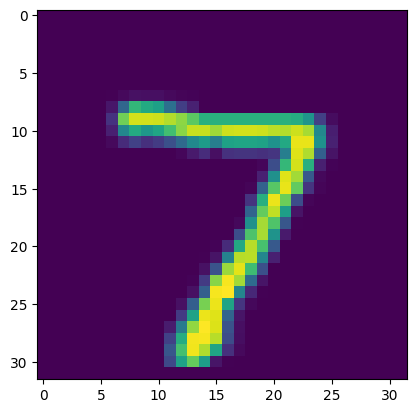

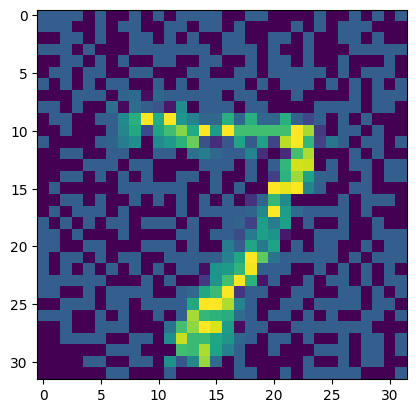

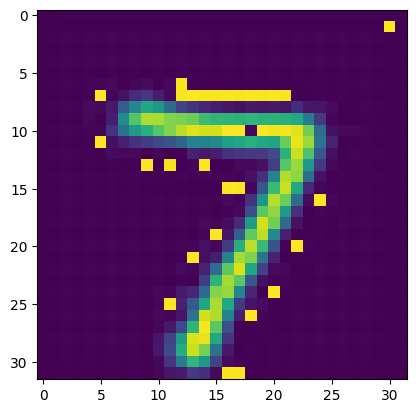

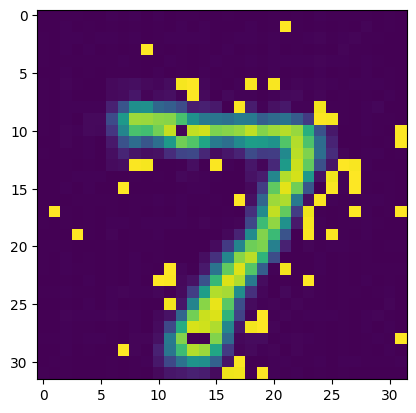

========= cifar10 =========
Files already downloaded and verified
Files already downloaded and verified


adv/sim training: 100%|████████████████| 391/391 [01:12<00:00,  5.41it/s, adv_acc=0.263]


[AST pgd] test acc: 0.3281, adv acc: 0.2656...


[AST square] test acc: 0.3281, adv acc: 0.1875...


adv/sim training: 100%|██████████████████| 391/391 [01:12<00:00,  5.43it/s, adv_acc=0.2]


[AST pgd] test acc: 0.3750, adv acc: 0.2969...


[AST square] test acc: 0.3750, adv acc: 0.2578...


adv/sim training: 100%|████████████████| 391/391 [01:11<00:00,  5.43it/s, adv_acc=0.163]


[AST pgd] test acc: 0.3906, adv acc: 0.2812...


[AST square] test acc: 0.3906, adv acc: 0.2344...


adv/sim training: 100%|████████████████| 391/391 [01:11<00:00,  5.45it/s, adv_acc=0.188]


[AST pgd] test acc: 0.3750, adv acc: 0.2500...


[AST square] test acc: 0.3750, adv acc: 0.2109...


adv/sim training: 100%|████████████████| 391/391 [01:11<00:00,  5.46it/s, adv_acc=0.237]


[AST pgd] test acc: 0.3750, adv acc: 0.2422...


[AST square] test acc: 0.3750, adv acc: 0.2109...


adv/sim training: 100%|████████████████| 391/391 [01:12<00:00,  5.36it/s, adv_acc=0.163]


[AST pgd] test acc: 0.3984, adv acc: 0.2578...


[AST square] test acc: 0.3984, adv acc: 0.2109...


adv/sim training: 100%|██████████████████| 391/391 [01:12<00:00,  5.38it/s, adv_acc=0.2]


[AST pgd] test acc: 0.3438, adv acc: 0.2734...


[AST square] test acc: 0.3438, adv acc: 0.2188...


adv/sim training: 100%|████████████████| 391/391 [01:12<00:00,  5.38it/s, adv_acc=0.275]


[AST pgd] test acc: 0.3359, adv acc: 0.2422...


[AST square] test acc: 0.3359, adv acc: 0.2031...


adv/sim training: 100%|████████████████| 391/391 [01:12<00:00,  5.36it/s, adv_acc=0.363]


[AST pgd] test acc: 0.3672, adv acc: 0.2891...


[AST square] test acc: 0.3672, adv acc: 0.1953...


adv/sim training: 100%|████████████████| 391/391 [01:12<00:00,  5.40it/s, adv_acc=0.237]


[AST pgd] test acc: 0.3750, adv acc: 0.2734...


[AST square] test acc: 0.3750, adv acc: 0.2578...


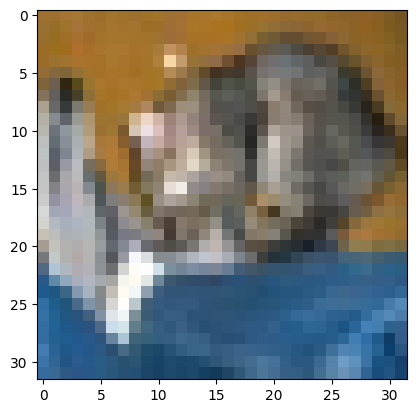

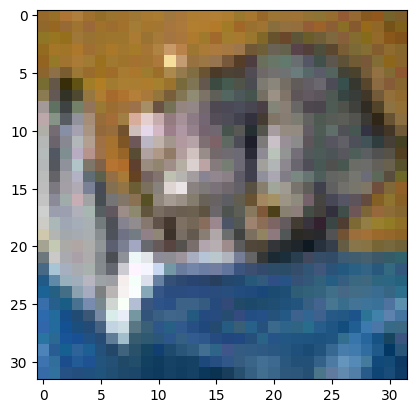

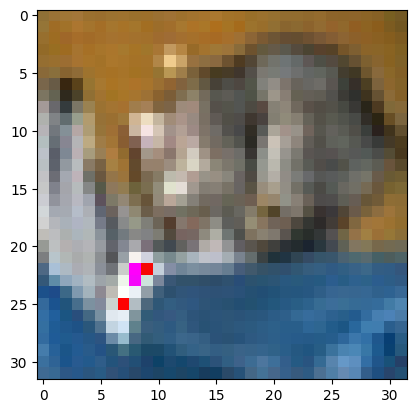

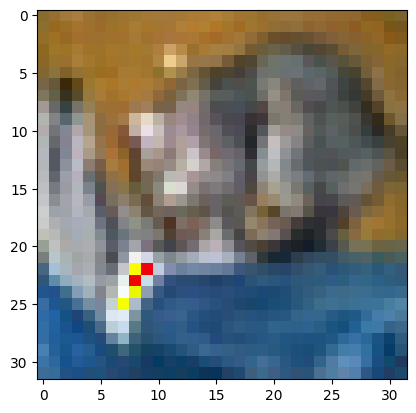

In [36]:
def main_check(args):
    set_seeds(args.seed)
    train_set, test_set = get_dataset(args.dataset)
    train_loader, test_loader = get_dataloader(train_set, test_set, args.batch_size)

    num_iter = 10
    aptnet = APTNet(args).to(args.device)
    dummy = rec_iptadvsim_training(args, train_loader, test_loader, 'pgd', num_iter, aptnet)

    testimgs, labels = next(iter(test_loader))
    testimgs = testimgs.to(args.device)
    labels = labels.to(args.device)
    advimgs = pgd_attack(args, testimgs, dummy, labels)
        
    show_image(testimgs[0])
    show_image(advimgs[0])
    show_image(dummy.iptnet(testimgs[0:1]))
    show_image(dummy.iptnet(advimgs[0:1]))

for dataset in ['mnist', 'cifar10']:
    print(f'========= {dataset} =========')
    args = default_arguments(dataset)
    main_check(args)


In [ ]:
args = default_arguments('cifar10')
args.vocab_size = 1024
main_check(args)
